# Superstore Sales

Objectives
* Aggregate Sales Data
* Correlations between sales and external factors.
* Identify top-performing products or regions.
* Investigate opportunities for cross- and up-selling.

### I. Imports and Setup

In [23]:
import dotenv
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import scipy.stats as st
import statsmodels as sm

In [2]:
# TODO 1: Replace current method of URL object creation with secure .env files, adding to .gitignore.

In [3]:
with open("authInfo.txt") as file:
    id = file.read()

# Create SQLAlchemy engine obj to act as conn
url = "mysql://{}/superstore".format(id)
engine = create_engine(url)

### II. Monthly Analysis

In [30]:
monthly_df = pd.read_sql_table(table_name="monthly_financials", con=engine.connect())
monthly_df.head(10)

,YearMonth,OrderVolume,MonthlySales,DiscountsValueGiven,MonthlyProfit
0,2014-01,79,14236.89,10.00,2450.19
1,2014-02,46,4519.89,8.10,862.31
2,2014-03,157,55691.01,26.30,498.73
3,2014-04,135,28295.34,14.85,3488.84
4,2014-05,122,23648.29,18.95,2738.71
5,2014-06,135,34595.13,23.22,4976.52
6,2014-07,143,33946.39,24.55,-841.48
7,2014-08,153,27909.47,20.05,5318.10
8,2014-09,268,81777.35,42.87,8328.10
9,2014-10,159,31453.39,25.45,3448.26


In [31]:
px.line(data_frame=monthly_df, x="YearMonth", y=["MonthlySales", "MonthlyProfit"], title="Time Series for Sales and Profit")

In [32]:
monthly_df.describe()

,OrderVolume,MonthlySales,DiscountsValueGiven,MonthlyProfit
count,48.000000,48.000000,48.000000,48.000000
mean,208.208333,47858.351042,32.522708,5966.605417
std,104.724148,25195.891228,16.275067,4288.699326
min,46.000000,4519.890000,8.000000,-3281.010000
25%,139.500000,29790.097500,23.655000,2939.562500
50%,173.000000,39803.245000,28.500000,4990.550000
75%,270.500000,65833.345000,42.307500,8742.505000
max,462.000000,118447.830000,73.890000,17885.310000


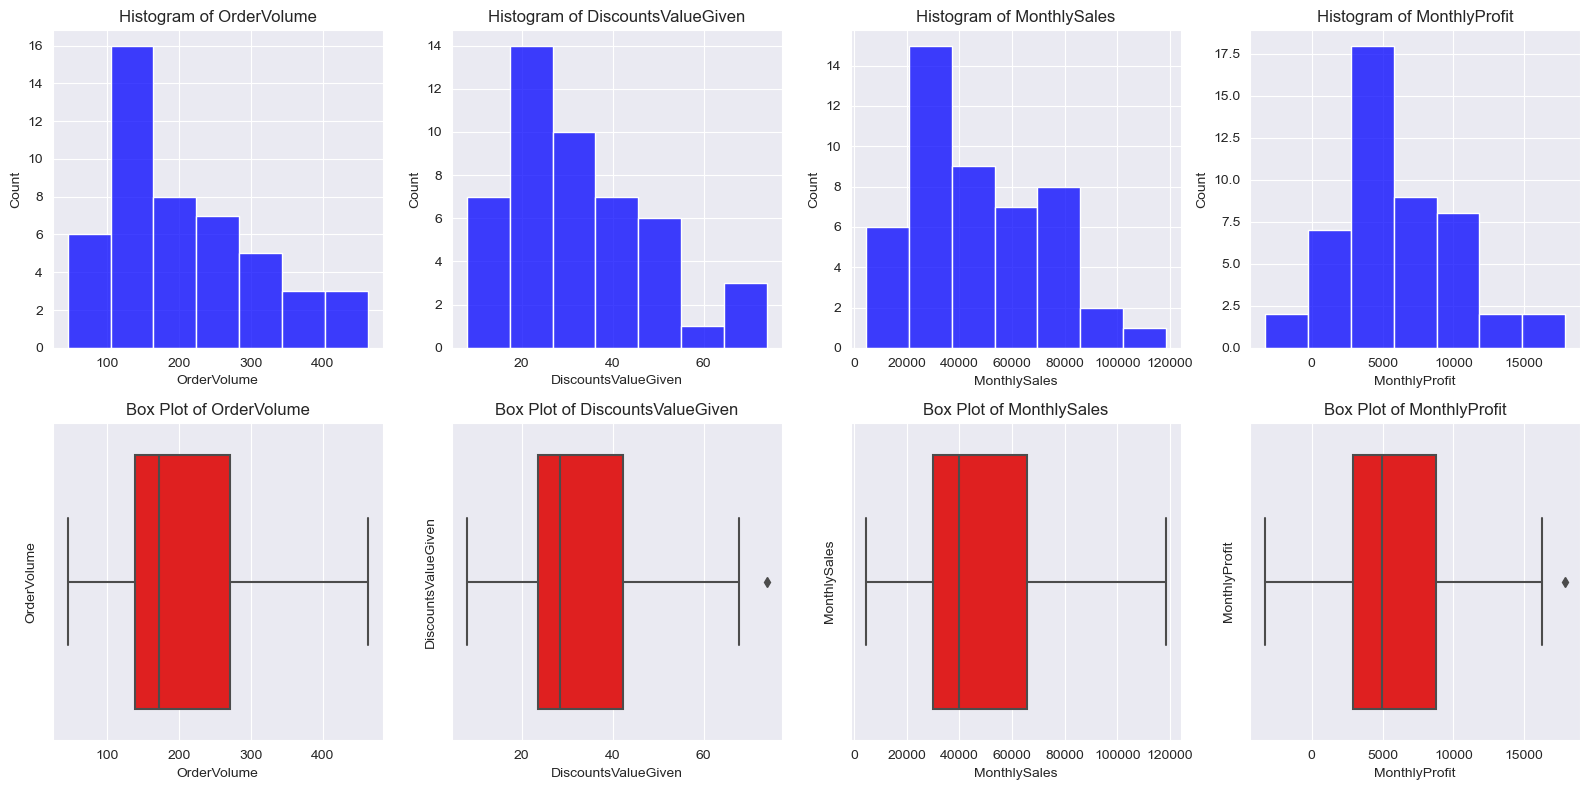

In [33]:
monthly_cols = ['OrderVolume', 'DiscountsValueGiven', 'MonthlySales', 'MonthlyProfit']

# Create 2 x 4 subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Create histograms in the first row
for i, col in enumerate(monthly_cols):
    sns.histplot(monthly_df[col], ax=axes[0, i], color='blue')
    axes[0, i].set_title(f'Histogram of {col}')
    axes[0, i].set_xlabel(col)

# Create box plots in the second row
for i, col in enumerate(monthly_cols):
    sns.boxplot(data=monthly_df, x=col, ax=axes[1, i], color='red')
    axes[1, i].set_title(f'Box Plot of {col}')
    axes[1, i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [35]:
# Shapiro-Wilk test for normality of the variables within monthly_df
print("Normal Variables:")
for label in monthly_cols:
    _, p = st.shapiro(monthly_df["MonthlyProfit"])
    if p > .05:
        print('\t * "{}"'.format(label))

Normal Variables:
	 * "OrderVolume"
	 * "DiscountsValueGiven"
	 * "MonthlySales"
	 * "MonthlyProfit"


### III. Categorical Analysis

In [37]:
# Category-SubCategory Financials (CSCF)
cscf_df = pd.read_sql_table(table_name='categorical_finances', con=engine.connect())
cscf_df

,Department,Division,DivisionVolume,AveragePurchase,DivisionSales,DiscountsValueGiven,DivisionProfit
0,Technology,Copiers,68,2198.94,149528.03,11.00,55617.82
1,Technology,Phones,889,371.21,330007.05,137.40,44515.73
2,Technology,Accessories,775,215.97,167380.32,60.80,41936.64
3,Office Supplies,Paper,1370,57.28,78479.21,102.60,34053.57
4,Office Supplies,Binders,1523,133.56,203412.73,567.00,30221.76
5,Furniture,Chairs,617,532.33,328449.10,105.00,26590.17
6,Office Supplies,Storage,846,264.59,223843.61,63.20,21278.83
7,Office Supplies,Appliances,466,230.76,107532.16,77.60,18138.01
8,Furniture,Furnishings,957,95.83,91705.16,132.40,13059.14
9,Office Supplies,Envelopes,254,64.87,16476.40,20.40,6964.18


In [42]:
cat_df = cscf_df[['Department', 'DivisionVolume', 'DivisionSales', 'DivisionProfit']].groupby(by="Department").sum()
cat_df = cat_df.rename(mapper={'DivisionVolume':'DepartmentVolume', 'DivisionSales':'DepartmentSales', 'DivisionProfit':'DepartmentProfit'}, axis=1)
cat_df

,DepartmentVolume,DepartmentSales,DepartmentProfit
Department,,,
Furniture,2121,741999.79,18451.27
Office Supplies,6026,719047.03,122490.81
Technology,1847,836154.03,145454.95


In [ ]:
# TODO: Recreate Pie Charts

**INSIGHT**: Technology makes up the smallest portion (< 20%) of orders, but accounts for about 30% of all Sales, and just over 50% of all Profits. Copiers, in particular, such the *Brother DCP1000* are the most profitable tech product our Superstore has to offer.

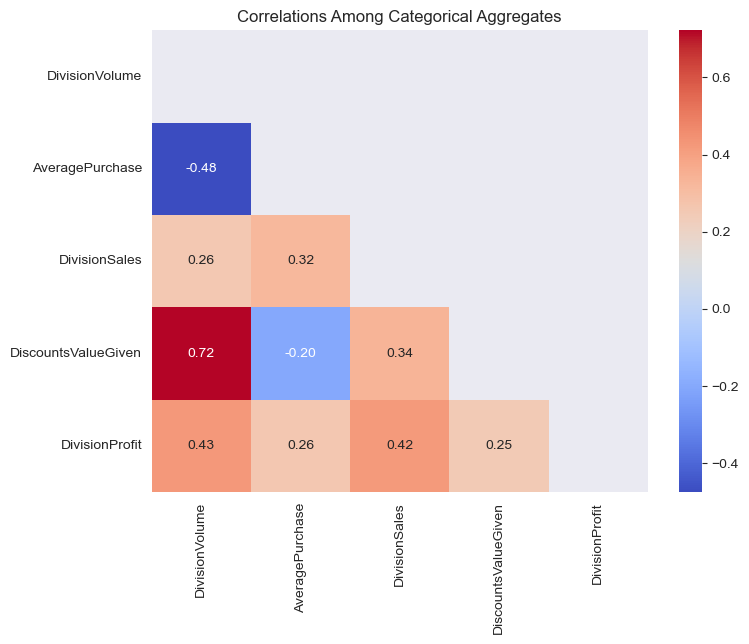

In [26]:
# Correlation matrix for numerical features in cat_df
corr_obj = cscf_df.drop(labels=['Department', 'Division'], axis=1, inplace=False).corr()
corr_obj

# Upper triangular mask
mask = np.triu(np.ones_like(corr_obj, dtype=bool))

# Plot heatmap of correlations, applying mask to reduce visual clutter
plt.figure(figsize=(8, 6))
sns.heatmap(corr_obj, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

plt.title("Correlations Among Categorical Aggregates")
plt.show()

**INSIGHT** Though not surprising - and hardly an insight at all - ```DiscountsValueGiven``` shows moderately high correlation (72%) with ```DivisionVolume```. So, application of discounts are likely to be accompanied by an increase the number of orders a Department (Category) or Division (Sub-Category) closes on.

In [ ]:
# TODO: Investigate who is buying copiers!